# Sentiment Analysis Model


### Importing the data


In [1]:
import pandas as pd

data = pd.read_csv("data.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4680 entries, 0 to 4679
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   index         4680 non-null   int64 
 1   name          4680 non-null   object
 2   product_url   4680 non-null   object
 3   query_url     4680 non-null   object
 4   review_url    4680 non-null   object
 5   rating        4680 non-null   int64 
 6   review_title  4680 non-null   object
 7   review        4680 non-null   object
dtypes: int64(2), object(6)
memory usage: 292.6+ KB


### Removing unneccssary columns from dataframe


In [2]:
data.drop(["index", "product_url", "query_url", "review_url"], axis=1, inplace=True)

### Cleaning the data


In [3]:
import nltk
import re
from nltk.corpus import stopwords

stopwords = set(stopwords.words("english"))


def clean(text):
    lemmatizer = nltk.WordNetLemmatizer()
    text = str(text).encode("ascii", "ignore").decode("ascii")
    text = str(text).lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"'s", " ", text)
    text = re.sub(r"'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"'re", " are ", text)
    text = re.sub(r"'d", " would ", text)
    text = re.sub(r"'ll", " will ", text)
    text = [word for word in text.split(" ") if word not in stopwords]
    text = " ".join(text)
    text = [lemmatizer.lemmatize(word) for word in text.split(" ")]
    text = " ".join(text)
    return text


data["name"] = data["name"].str.lower()
data["review_title"] = data["review_title"].apply(clean)
data["review"] = data["review"].apply(clean)
data.sample(5)

,name,rating,review_title,review
613,"motorola g42 (atlantic green, 64 gb)",4,really nice,best segment... camera decent day time.. low l...
1322,nokia 105 plus,3,fair,"battery life short, lava phone great battery."
353,"infinix hot 30i (marigold, 64 gb)",5,mind-blowing purchase,nice
344,"infinix hot 30i (marigold, 64 gb)",1,waste money!,hang waste quality
469,"infinix note 12 pro 5g (force black, 128 gb)",5,simply awesome,fichuer setting goodvery good camera


### Sentiment Analysis


In [4]:
from nltk.sentiment import SentimentIntensityAnalyzer

sentiments = SentimentIntensityAnalyzer()
data["positive"] = [sentiments.polarity_scores(i)["pos"] for i in data["review"]]
data["negative"] = [sentiments.polarity_scores(i)["neg"] for i in data["review"]]
data["neutral"] = [sentiments.polarity_scores(i)["neu"] for i in data["review"]]

In [5]:
def sentiment_score(x):
    a = x.positive
    b = x.negative
    c = x.neutral
    if a > b and a > c:
        sentiment = "Positive"
    elif b > a and b > c:
        sentiment = "Negative"
    else:
        sentiment = "Neutral"
    return sentiment


name_sentiment = data[["name", "positive", "negative", "neutral"]].apply(
    sentiment_score, axis=1
)
data["sentiment"] = name_sentiment

### Using Wordcloud to visualize the reviews data


Positive Sentiment Data Size:2183
Negative Sentiment Data Size:209
Neutral Sentiment Data Size:2129
Ambiguous Sentiment Data Size:159
Positive Sentiment Data Size:2183


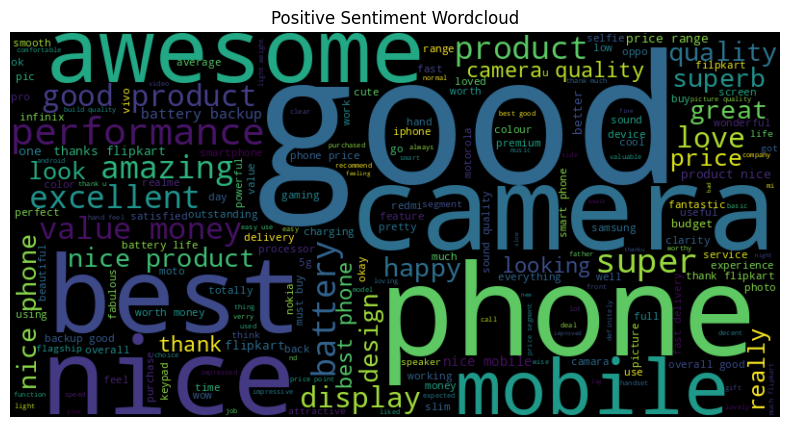

Neutral Sentiment Data Size:2129


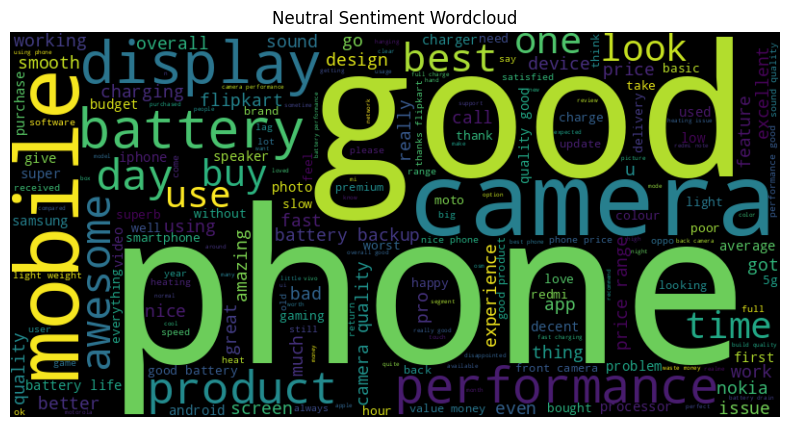

Negative Sentiment Data Size:209


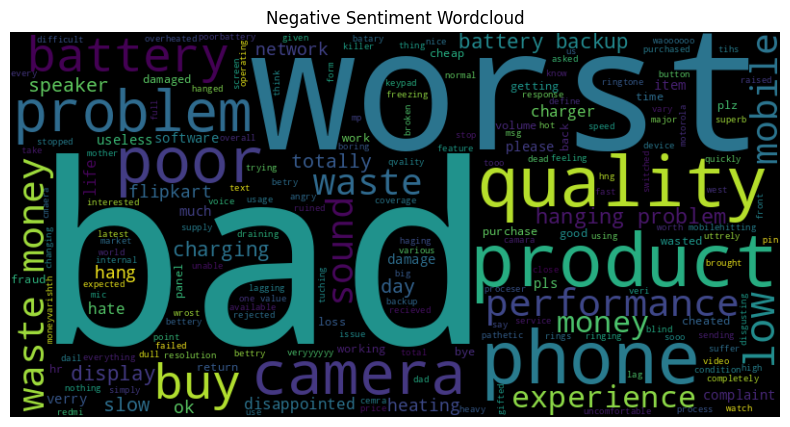

In [6]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

min_intensity = 0.5

# Positive
reviews = data.query(f"positive>{min_intensity}").review
print(f"positive sentiment data size:{len(reviews)}".title())
text_combined = " ".join(reviews)
positive_wordcloud = WordCloud(width=800, height=400).generate(text_combined)

# Negative
reviews = data.query(f"negative>{min_intensity}").review
print(f"negative sentiment data size:{len(reviews)}".title())
text_combined = " ".join(reviews)
negative_wordcloud = WordCloud(width=800, height=400).generate(text_combined)

# Neutral
reviews = data.query(f"neutral>{min_intensity}").review
print(f"neutral sentiment data size:{len(reviews)}".title())
text_combined = " ".join(reviews)
neutral_wordcloud = WordCloud(width=800, height=400).generate(text_combined)

# Ambiguous
reviews = data.query(
    f"not(positive>{min_intensity}|negative>{min_intensity}|neutral>{min_intensity})"
).review
print(f"Ambiguous Sentiment Data Size:{len(reviews)}")
text_combined = " ".join(reviews)
ambiguous_wordcloud = WordCloud(width=800, height=400).generate(text_combined)

for sentiment in ["positive", "neutral", "negative"]:
    reviews = data.query(f"{sentiment}>{min_intensity}").review
    print(f"{sentiment} sentiment data size:{len(reviews)}".title())
    text_combined = " ".join(reviews)
    wordcloud = WordCloud(width=800, height=400).generate(text_combined)
    plt.figure(figsize=(10, 5))
    plt.title(f"{sentiment} sentiment wordcloud".title())
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

### Creating word lists


In [7]:
def filter(word_cloud: WordCloud) -> list:
    excluded_words = [
        "good",
        "awesome",
        "best",
        "nice",
        "good good",
        "superb",
        "super",
        "thank",
        "amazing",
        "excellent",
        "great",
        "super",
        "happy",
        "love",
        "bad",
        "worst",
        "poor",
        "product",
        "mobile",
        "low",
        "waste",
        "waste money",
        "flipkart",
        "hate",
        "day",
    ]
    return [i for i in word_cloud.words_.keys() if i.lower() not in excluded_words]


words = {
    "positive": filter(positive_wordcloud),
    "negative": filter(negative_wordcloud),
    "neutral": filter(neutral_wordcloud),
    "ambiguous": filter(ambiguous_wordcloud),
}

### Vectorize the reviews


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
reviews_corpus = vectorizer.fit_transform(data.review)
reviews_corpus.shape

(4680, 5843)

### Encoding the target


In [9]:
from sklearn.preprocessing import LabelEncoder

label_enc = LabelEncoder()
print(data.sentiment)
sentiment = pd.DataFrame(label_enc.fit_transform(data["sentiment"]))
print(sentiment)
sentiment.shape

0       Positive
1        Neutral
2       Positive
3        Neutral
4       Positive
          ...   
4675    Positive
4676     Neutral
4677    Positive
4678    Positive
4679    Positive
Name: sentiment, Length: 4680, dtype: object
      0
0     2
1     1
2     2
3     1
4     2
...  ..
4675  2
4676  1
4677  2
4678  2
4679  2

[4680 rows x 1 columns]


(4680, 1)

### Splitting the dataset for training and testing


In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(
    reviews_corpus, sentiment, test_size=0.33, random_state=0
)
Y_train = Y_train.to_numpy().ravel()
Y_test = Y_test.to_numpy().ravel()
print("Train data shape ", X_train.shape, Y_train.shape)
print("Test data shape ", X_test.shape, Y_test.shape)

Train data shape  (3135, 5843) (3135,)
Test data shape  (1545, 5843) (1545,)


### Building classifier models and comparing them


In [11]:
from sklearn.metrics import confusion_matrix

In [12]:
from sklearn.naive_bayes import MultinomialNB

classifier = MultinomialNB().fit(X_train, Y_train)
Y_pred = classifier.predict(X_test)
print(f"Accuracy: {classifier.score(X_test, Y_test)}")
print("Confusion Matrix:")
print(confusion_matrix(Y_pred, Y_test))

Accuracy: 0.8129449838187702
Confusion Matrix:
[[  0   0   0]
 [ 69 595  78]
 [  3 139 661]]


In [13]:
from sklearn.tree import DecisionTreeClassifier

classifier = DecisionTreeClassifier().fit(X_train, Y_train)
Y_pred = classifier.predict(X_test)
print(f"Accuracy: {classifier.score(X_test, Y_test)}")
print("Confusion Matrix:")
print(confusion_matrix(Y_pred, Y_test))

Accuracy: 0.8116504854368932
Confusion Matrix:
[[ 55  11   3]
 [ 13 592 129]
 [  4 131 607]]


In [14]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier().fit(X_train, Y_train)
Y_pred = classifier.predict(X_test)
print(f"Accuracy: {classifier.score(X_test, Y_test)}")
print("Confusion Matrix:")
print(confusion_matrix(Y_pred, Y_test))

Accuracy: 0.8601941747572815
Confusion Matrix:
[[ 51   5   2]
 [ 21 642 101]
 [  0  87 636]]


In [15]:
from sklearn.ensemble import BaggingClassifier

classifier = BaggingClassifier().fit(X_train, Y_train)
Y_pred = classifier.predict(X_test)
print(f"Accuracy: {classifier.score(X_test, Y_test)}")
print("Confusion Matrix:")
print(confusion_matrix(Y_pred, Y_test))

Accuracy: 0.8530744336569579
Confusion Matrix:
[[ 58  11   3]
 [ 14 632 108]
 [  0  91 628]]


In [16]:
from sklearn.ensemble import GradientBoostingClassifier

classifier = GradientBoostingClassifier().fit(X_train, Y_train)
Y_pred = classifier.predict(X_test)
print(f"Accuracy: {classifier.score(X_test, Y_test)}")
print("Confusion Matrix:")
print(confusion_matrix(Y_pred, Y_test))

Accuracy: 0.8524271844660194
Confusion Matrix:
[[ 59   9   3]
 [ 13 645 123]
 [  0  80 613]]


In [17]:
import pickle

with open("classifier.model", "wb") as f:
    model = pickle.dumps(classifier)
    f.write(model)

In [18]:
with open("classifier.model", "rb") as f:
    model = pickle.loads(f.read())
    Y_pred = model.predict(X_test)
    print(f"Accuracy: {model.score(X_test, Y_test)}")
    print("Confusion Matrix:")
    print(confusion_matrix(Y_pred, Y_test))

Accuracy: 0.8524271844660194
Confusion Matrix:
[[ 59   9   3]
 [ 13 645 123]
 [  0  80 613]]


In [19]:
from model_db import Storage


class Model:
    def __init__(self, model, *args, **kwargs) -> None:
        self.model = model
        self.args = args
        self.kwargs = kwargs

    def predict(self, *args, **kwargs):
        from numpy import bincount, array, argmax
        import requests
        from bs4 import BeautifulSoup
        import pandas as pd
        import re
        from nltk import WordNetLemmatizer

        review_url = "https://www.flipkart.com/poco-c51-power-black-64-gb/product-reviews/itm62bcd2634619e"
        pages = 3
        reviews_list = []
        for p in range(1, pages + 1):
            url = review_url + f"?sortOrder=MOST_HELPFUL&page={p}"
            webpage = requests.get(url)
            soup = BeautifulSoup(webpage.content, "html.parser")
            reviews_html = soup.find("div", {"class": "_1YokD2 _3Mn1Gg col-9-12"}).find_all(
                "div", {"class": "_1AtVbE col-12-12"}
            )
            for id in range(len(reviews_html)):
                if id > 1 and id < 12:
                    try:
                        review = reviews_html[id].find("div", {"class": ""}).div.text
                        title = reviews_html[id].div.div.div.div.p.text
                        rating = reviews_html[id].div.div.div.div.div.text
                        reviews_list.append(review)
                    except Exception as e:
                        print(f"Error:{e}")
        df=pd.DataFrame({"review":reviews_list})
        def clean(text):
            lemmatizer = WordNetLemmatizer()
            text = str(text).encode("ascii", "ignore").decode("ascii")
            text = str(text).lower()
            text = re.sub(r"what's", "what is ", text)
            text = re.sub(r"'s", " ", text)
            text = re.sub(r"'ve", " have ", text)
            text = re.sub(r"can't", "can not ", text)
            text = re.sub(r"n't", " not ", text)
            text = re.sub(r"i'm", "i am ", text)
            text = re.sub(r"'re", " are ", text)
            text = re.sub(r"'d", " would ", text)
            text = re.sub(r"'ll", " will ", text)
            text = [word for word in text.split(" ") if word not in self.kwargs["stopwords"]]
            text = " ".join(text)
            text = [lemmatizer.lemmatize(word) for word in text.split(" ")]
            text = " ".join(text)
            return text

        df["review"] = df["review"].apply(clean)
        reviews_corpus = self.kwargs["vectorizer"].transform(df.review)
        pred = self.model.predict(reviews_corpus)
        counts = bincount((array(pred)))
        match argmax(counts):
            case 0:
                return "This product is not worth buying."
            case 1:
                return "This product seems to be ok."
            case 2:
                return "The product is worth buying."
            case _:
                return False


mdl = Model(classifier, vectorizer=vectorizer,stopwords=stopwords)
mdl.predict(
    url="https://www.flipkart.com/samsung-galaxy-f13-sunrise-copper-64-gb/p/itm0d8c65ec17621"
)
Storage().add_model(
    name="product_sentiment_analysis",
    description="A model which scrapes reviews from Flipkart, analyses the reviews and returns  ",
    model=mdl,
    input_fields=[{"identifier": "url", "label": "Enter URL:", "type": "text"}],
)

/home/User/Programs/Product_Sentiment_Analysis/model/model_db.py:30: UserWarning: DB_NOT_FOUND: Creating a new models database
  warnings.warn("DB_NOT_FOUND: Creating a new models database")
